<a href="https://colab.research.google.com/github/freida20git/nanoparticle-classification/blob/main/cubes/cubes_Silhouette_test_DINOV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import torch
import torchvision.transforms as T
from PIL import Image
import os
from tqdm.notebook import tqdm
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import pandas as pd

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]


🔄 Processing: pad_center_224


100%|██████████| 20/20 [00:01<00:00, 10.17it/s]



🔄 Processing: resize_224


100%|██████████| 20/20 [00:01<00:00, 10.38it/s]



🔄 Processing: resize_50_pad


100%|██████████| 20/20 [00:01<00:00, 10.28it/s]



🔄 Processing: resize_100_pad


100%|██████████| 20/20 [00:01<00:00, 10.55it/s]



🔄 Processing: resize_150_pad


100%|██████████| 20/20 [00:01<00:00, 10.59it/s]



🔄 Processing: resize_200_pad


100%|██████████| 20/20 [00:01<00:00, 10.52it/s]



🔄 Processing: grid_2x2


100%|██████████| 20/20 [00:01<00:00, 10.36it/s]
/tmp/ipython-input-10-3745454571.py:174: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout(rect=[0, 0, 1, 0.95])
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


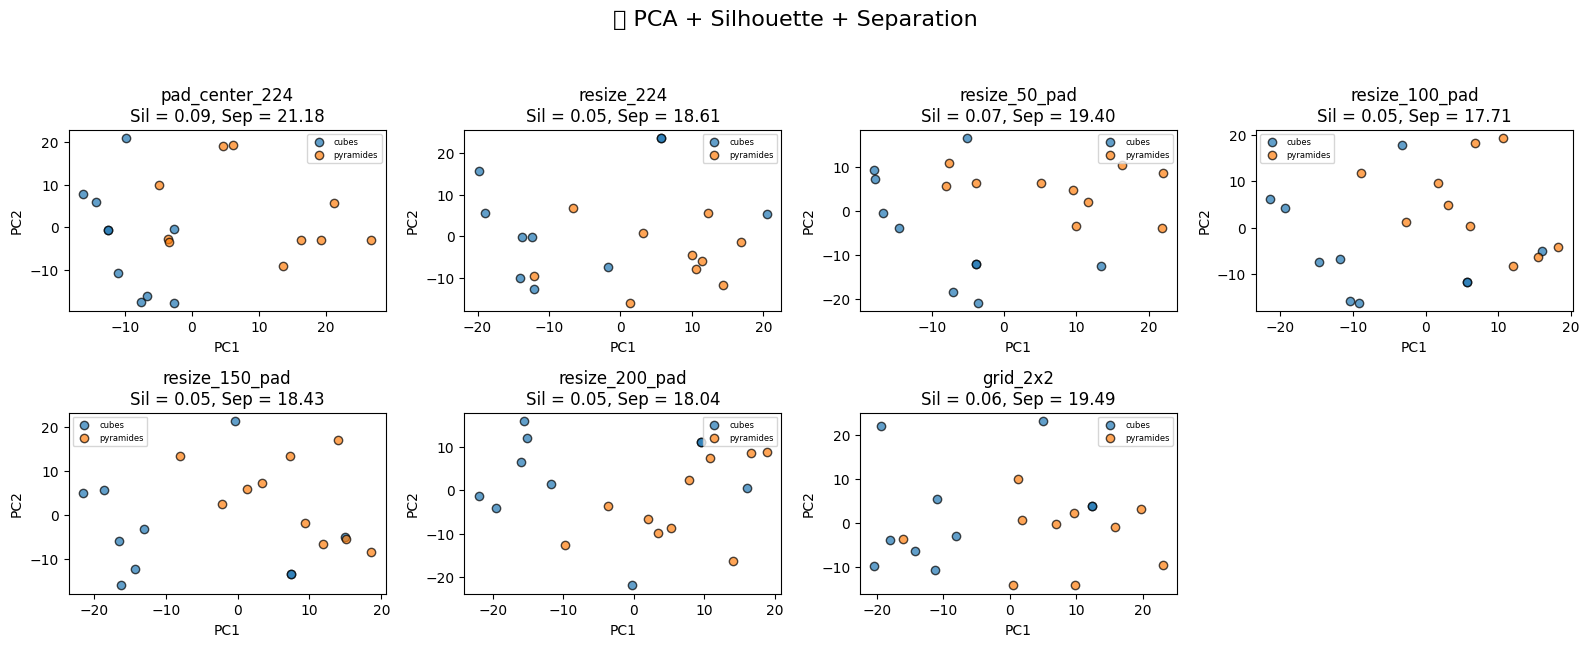


📋 Summary Table:
Transformation  Silhouette Score  Separation Score
pad_center_224             0.091            21.179
 resize_50_pad             0.073            19.404
      grid_2x2             0.063            19.487
    resize_224             0.054            18.611
resize_150_pad             0.051            18.430
resize_100_pad             0.047            17.705
resize_200_pad             0.045            18.039


In [ ]:
# === Imports ===
import os
import torch
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import timm
from timm.data import resolve_model_data_config, create_transform

# === Load DINOv2 Model from timm ===
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dinov2_model = timm.create_model('vit_base_patch14_dinov2', pretrained=True, num_classes=0)
dinov2_model.to(device).eval()

# === Create Default Transform ===
data_config = resolve_model_data_config(dinov2_model)
default_transform = create_transform(**data_config, is_training=False)

# === Image Transformations ===
class PadToCenter224:
    def __call__(self, img):
        w, h = img.size
        scale = min(224 / w, 224 / h, 1.0)
        new_w, new_h = int(w * scale), int(h * scale)
        img = img.resize((new_w, new_h), Image.BICUBIC)
        canvas = Image.new("RGB", (224, 224), (0, 0, 0))
        left = (224 - new_w) // 2
        top = (224 - new_h) // 2
        canvas.paste(img, (left, top))
        return default_transform(canvas)

def resize_and_pad(size):
    class ResizeAndPad:
        def __call__(self, img):
            img = img.resize((size, size), Image.BICUBIC)
            canvas = Image.new("RGB", (224, 224), (0, 0, 0))
            canvas.paste(img, ((224 - size) // 2, (224 - size) // 2))
            return default_transform(canvas)
    return ResizeAndPad()

class Duplicate2x2Grid:
    def __call__(self, img):
        w, h = img.size
        grid_img = Image.new("RGB", (w * 2, h * 2))
        for i in range(2):
            for j in range(2):
                grid_img.paste(img, (i * w, j * h))
        grid_img = grid_img.resize((224, 224), Image.BICUBIC)
        return default_transform(grid_img)

transforms_dict = {
    "pad_center_224": PadToCenter224(),
    "resize_224": default_transform,
    "resize_50_pad": resize_and_pad(50),
    "resize_100_pad": resize_and_pad(100),
    "resize_150_pad": resize_and_pad(150),
    "resize_200_pad": resize_and_pad(200),
    "grid_2x2": Duplicate2x2Grid(),
}

# === Utility Functions ===
def get_image_paths(directory):
    image_paths = []
    for class_dir in os.listdir(directory):
        class_path = os.path.join(directory, class_dir)
        if os.path.isdir(class_path):
            for img in os.listdir(class_path):
                if img.lower().endswith(('.jpg', '.png', '.jpeg')):
                    image_paths.append(os.path.join(class_path, img))
    return image_paths

def extract_embeddings_with_transform(image_paths, transform):
    embeddings = []
    labels = []
    with torch.no_grad():
        for path in tqdm(image_paths):
            img = Image.open(path).convert("RGB")
            tensor_img = transform(img).unsqueeze(0).to(device)
            feats = dinov2_model.forward_features(tensor_img)
            pooled = dinov2_model.forward_head(feats, pre_logits=True)
            embeddings.append(pooled.squeeze().cpu().numpy())
            labels.append(os.path.basename(os.path.dirname(path)))
    return np.array(embeddings), np.array(labels)

def compute_class_separation(X, y):
    classes = np.unique(y)
    centroids = [np.mean(X[y == cls], axis=0) for cls in classes]
    dists = []
    for i in range(len(centroids)):
        for j in range(i + 1, len(centroids)):
            d = np.linalg.norm(centroids[i] - centroids[j])
            dists.append(d)
    return np.mean(dists)

def evaluate_classification_models(X, y, cv=5):
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    scores = {}

    models = {
        "LogisticRegression": LogisticRegression(max_iter=1000),
        "SVM": SVC(),
        "RandomForest": RandomForestClassifier()
    }

    for model_name, model in models.items():
        cv_scores = cross_val_score(model, X, y_encoded, cv=cv, scoring='accuracy')
        scores[model_name] = cv_scores.mean()

    return scores

# === Set data paths ===
base_dir = "/content/drive/MyDrive/cubes_new"
train_dir = os.path.join(base_dir, "cubes_train")
train_images = get_image_paths(train_dir)

# === Score dictionaries + Embeddings storage ===
silhouette_scores = {}
separation_scores = {}
all_embeddings = {}

# === Visualization ===
n_plots = len(transforms_dict)
rows = 3
cols = 4
plt.figure(figsize=(cols * 4, rows * 3))

for i, (name, transform) in enumerate(transforms_dict.items(), 1):
    print(f"\n🔄 Processing: {name}")

    # Step 1: Extract embeddings
    X, y = extract_embeddings_with_transform(train_images, transform)

    # Save embedding
    all_embeddings[name] = {"X": X, "y": y}

    # Step 2: Compute metrics
    sil_score = silhouette_score(X, y)
    sep_score = compute_class_separation(X, y)

    silhouette_scores[name] = sil_score
    separation_scores[name] = sep_score

    # Step 3: PCA for visualization
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    classes = np.unique(y)
    class_to_color = {cls: plt.cm.tab10(i % 10) for i, cls in enumerate(classes)}

    plt.subplot(rows, cols, i)
    for cls in classes:
        idx = y == cls
        plt.scatter(
            X_pca[idx, 0], X_pca[idx, 1],
            label=cls,
            color=class_to_color[cls],
            alpha=0.7, edgecolors='k'
        )
    plt.title(f"{name}\nSil = {sil_score:.2f}, Sep = {sep_score:.2f}")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend(fontsize=6)

plt.suptitle("📊 PCA + Silhouette + Separation", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# === Summary Table ===
summary_df = pd.DataFrame({
    "Transformation": list(silhouette_scores.keys()),
    "Silhouette Score": list(silhouette_scores.values()),
    "Separation Score": list(separation_scores.values())
})

summary_df = summary_df.sort_values(by="Silhouette Score", ascending=False)

print("\n📋 Summary Table:")
print(summary_df.to_string(index=False, float_format="%.3f"))


In [ ]:
# === 🔽 בחירת embedding סופי לשימוש בהמשך ===
chosen_transform = "resize_50_pad"  # 🔁 שנה לפי הצורך

X_train = all_embeddings[chosen_transform]["X"]
y_train = all_embeddings[chosen_transform]["y"]

print(f"\nChosen embedding: {chosen_transform}")


Chosen embedding: resize_50_pad


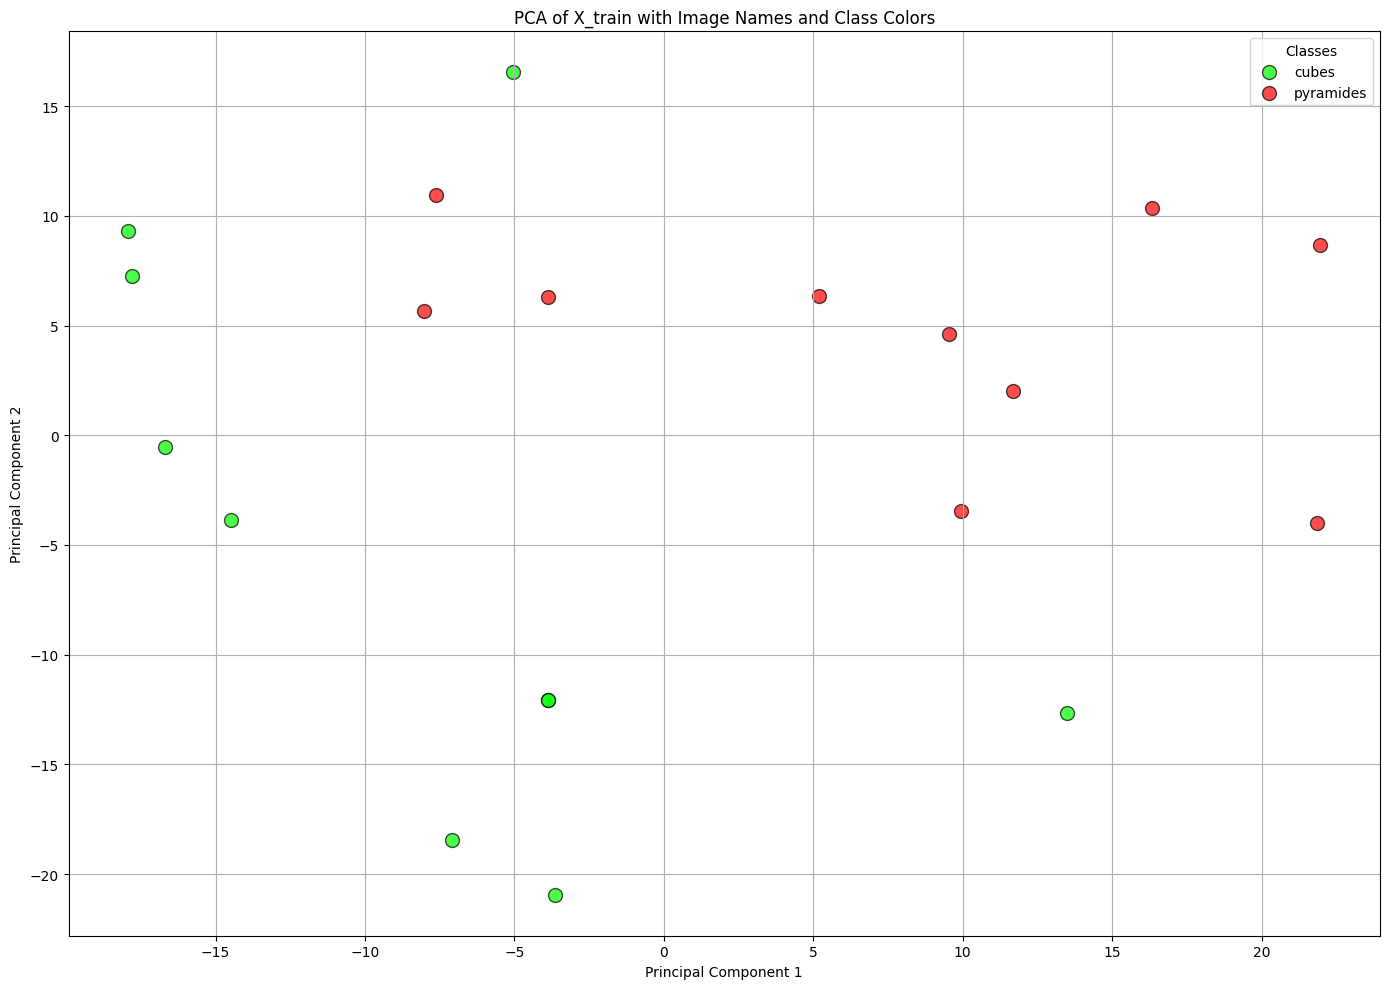

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
import os

# המרת תוויות לקטגוריות מספריות
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

# פלטת צבעים RGB (מותאמת לפי מספר מחלקות)
color_palette_rgb = [
    (0, 1, 0),      # Green
    (1, 0, 0),      # Blue
    (0, 0, 1),      # Red
    (1, 1, 0),      # Cyan
    (0, 1, 1),      # Yellow
    (1, 0, 1),      # Magenta
    (0.5, 0, 0),    # Dark Blue
    (0, 0.5, 0),    # Dark Green
    (0, 0, 0.5),    # Dark Red
    (0.5, 0.5, 0),  # Teal
]
num_classes = len(np.unique(y_encoded))
colors = [color_palette_rgb[i % len(color_palette_rgb)] for i in y_encoded]

# ציור
plt.figure(figsize=(14, 10))
for class_index in range(num_classes):
    idx = y_encoded == class_index
    plt.scatter(
        X_pca[idx, 0],
        X_pca[idx, 1],
        s=100,
        color=color_palette_rgb[class_index % len(color_palette_rgb)],
        label=le.inverse_transform([class_index])[0],
        edgecolors='k',
        alpha=0.7
    )

# הגדרות גרף
plt.legend(title="Classes")
plt.title("PCA of X_train with Image Names and Class Colors")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()



Evaluating transformation: pad_center_224


100%|██████████| 186/186 [00:18<00:00, 10.23it/s]


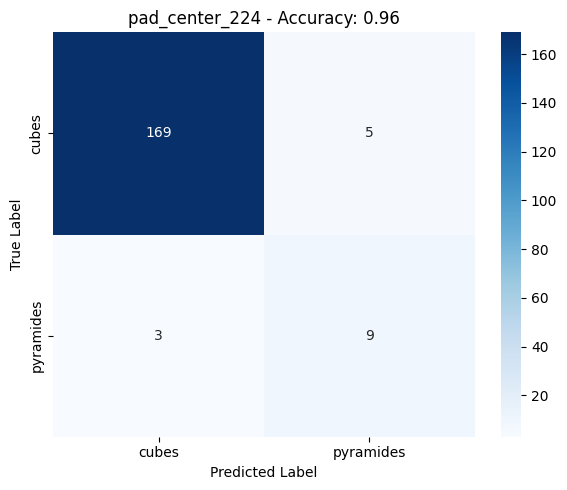


Classification Report for pad_center_224:

              precision    recall  f1-score   support

       cubes       0.98      0.97      0.98       174
   pyramides       0.64      0.75      0.69        12

    accuracy                           0.96       186
   macro avg       0.81      0.86      0.83       186
weighted avg       0.96      0.96      0.96       186


Evaluating transformation: resize_224


100%|██████████| 186/186 [00:18<00:00, 10.24it/s]


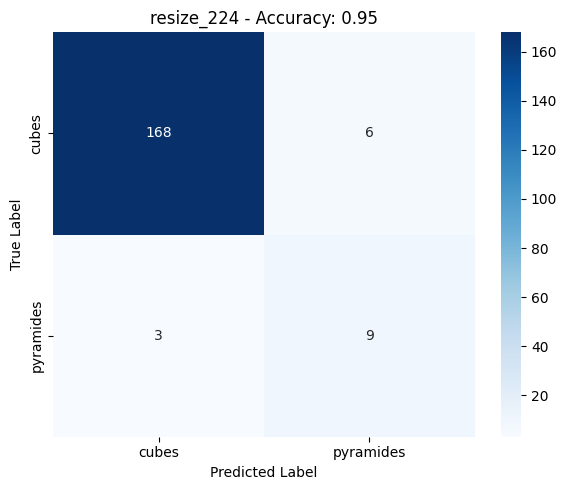


Classification Report for resize_224:

              precision    recall  f1-score   support

       cubes       0.98      0.97      0.97       174
   pyramides       0.60      0.75      0.67        12

    accuracy                           0.95       186
   macro avg       0.79      0.86      0.82       186
weighted avg       0.96      0.95      0.95       186


Evaluating transformation: resize_50_pad


100%|██████████| 186/186 [00:18<00:00, 10.33it/s]


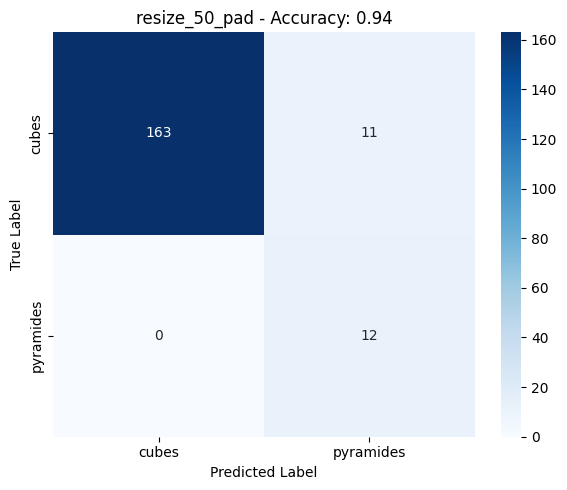


Classification Report for resize_50_pad:

              precision    recall  f1-score   support

       cubes       1.00      0.94      0.97       174
   pyramides       0.52      1.00      0.69        12

    accuracy                           0.94       186
   macro avg       0.76      0.97      0.83       186
weighted avg       0.97      0.94      0.95       186


Evaluating transformation: resize_100_pad


100%|██████████| 186/186 [00:17<00:00, 10.41it/s]


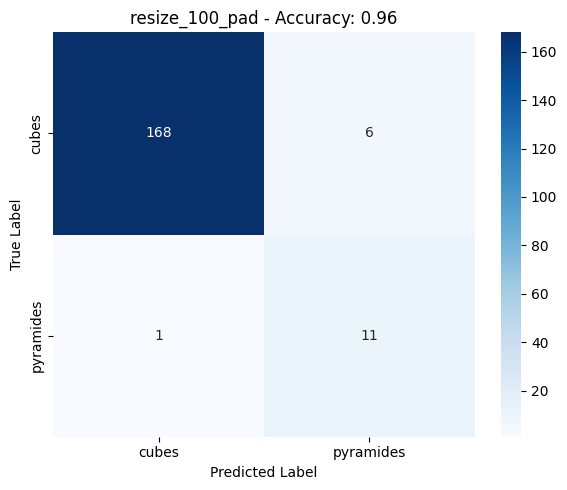


Classification Report for resize_100_pad:

              precision    recall  f1-score   support

       cubes       0.99      0.97      0.98       174
   pyramides       0.65      0.92      0.76        12

    accuracy                           0.96       186
   macro avg       0.82      0.94      0.87       186
weighted avg       0.97      0.96      0.97       186


Evaluating transformation: resize_150_pad


100%|██████████| 186/186 [00:17<00:00, 10.37it/s]


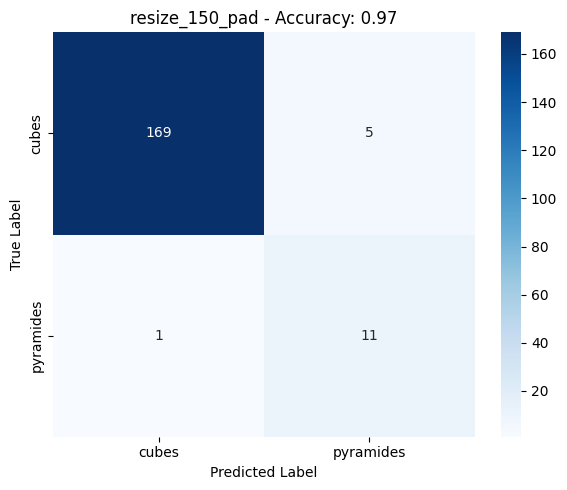


Classification Report for resize_150_pad:

              precision    recall  f1-score   support

       cubes       0.99      0.97      0.98       174
   pyramides       0.69      0.92      0.79        12

    accuracy                           0.97       186
   macro avg       0.84      0.94      0.88       186
weighted avg       0.97      0.97      0.97       186


Evaluating transformation: resize_200_pad


100%|██████████| 186/186 [00:18<00:00, 10.19it/s]


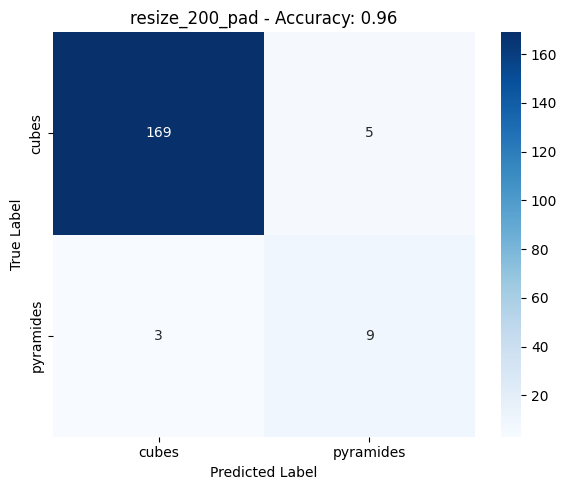


Classification Report for resize_200_pad:

              precision    recall  f1-score   support

       cubes       0.98      0.97      0.98       174
   pyramides       0.64      0.75      0.69        12

    accuracy                           0.96       186
   macro avg       0.81      0.86      0.83       186
weighted avg       0.96      0.96      0.96       186


Evaluating transformation: grid_2x2


100%|██████████| 186/186 [00:18<00:00, 10.21it/s]


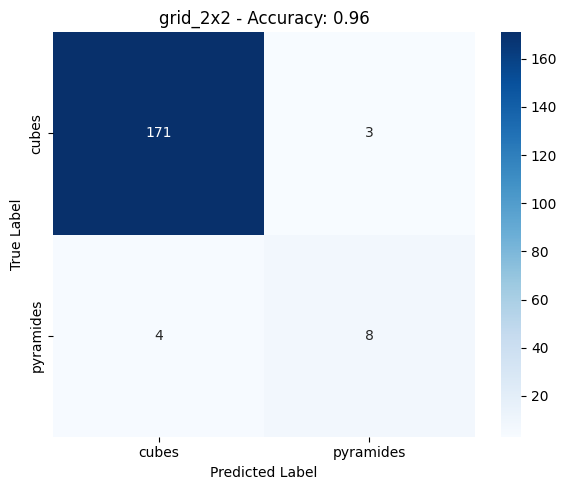


Classification Report for grid_2x2:

              precision    recall  f1-score   support

       cubes       0.98      0.98      0.98       174
   pyramides       0.73      0.67      0.70        12

    accuracy                           0.96       186
   macro avg       0.85      0.82      0.84       186
weighted avg       0.96      0.96      0.96       186



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

test_dir = os.path.join(base_dir, "cubes_test")
test_images = get_image_paths(test_dir)

results = {}

for name, transform in transforms_dict.items():
    print(f"\nEvaluating transformation: {name}")

    # Load train and test embeddings
    X_train, y_train = all_embeddings[name]["X"], all_embeddings[name]["y"]
    X_test, y_test = extract_embeddings_with_transform(test_images, transform)

    # Encode labels
    le = LabelEncoder()
    y_train_encoded = le.fit_transform(y_train)
    y_test_encoded = le.transform(y_test)

    # Train Logistic Regression
    model = LogisticRegression(max_iter=1000)
    model.fit(X_train, y_train_encoded)

    # Predict and evaluate
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test_encoded, y_pred)
    cm = confusion_matrix(y_test_encoded, y_pred)

    results[name] = {
        "accuracy": acc,
        "confusion_matrix": cm,
        "labels": le.classes_
    }

    # === Plot Confusion Matrix ===
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"{name} - Accuracy: {acc:.2f}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

    # === Classification Report ===
    report = classification_report(y_test_encoded, y_pred, target_names=le.classes_)
    print(f"\nClassification Report for {name}:\n")
    print(report)
